# Seminar Deep Learning for Computer Vision - Image Classification (Luca Kretz)

### Evaluate Imagenette

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
import random
import os
import matplotlib.pyplot as plt
import datetime
import json
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Load the pre-trained NASNet model. It was trained on the Imagenet dataset.

In [0]:
nasnet_model = tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3), 
                                                       include_top=True, 
                                                       weights='imagenet')

Load the Imagenette data set (subset of ImageNet with 10 classes)

In [0]:
# load smaller subset of Imagenet with 10 classes
imagenet_dataset = tfds.load("imagenette/320px")
# select only the validation data
evaluation_data = imagenet_dataset['validation']
# load txt file containing the 10 class names
with open('imagenette_labels.txt', 'r') as file_handle:
    imagenette_labels = file_handle.readlines() 

Pre-process the image data

In [0]:
# funktion to get the right amount of samples
# and get the right shape for the net input
def get_data_set(data, limit = 1000):
    all_img, all_labels = [],[]
    for i, sample in enumerate(data):
        img, label = sample["image"], sample["label"]
        img = tf.image.resize(img,(224,224))
        img = img/255.0
        img = (img-0.5)*2.0
        all_img.append(img)
        all_labels.append(label)
        
        if i == limit - 1:
            break
    return (all_img, all_labels)

In [0]:
# load all Imagenet labels with their matching class names
with open('imagenet_labels.txt','r') as inf:
    id2lbl = eval(inf.read())
# create the evaluation set
(evaluation_images, evaluation_labels) = get_data_set(evaluation_data)

(-0.5, 223.5, 223.5, -0.5)

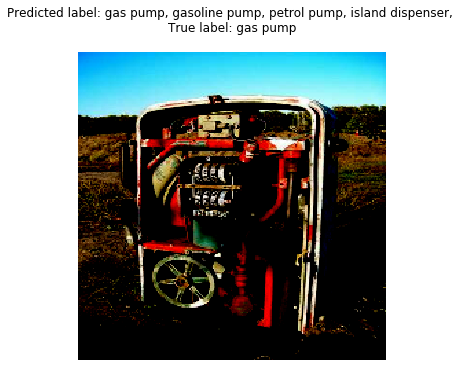

In [0]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.tight_layout()

# Readout a random image and the corresponding label.
rand_idx = random.randint(0,len(evaluation_labels))
img = evaluation_images[rand_idx]
lbl = evaluation_labels[rand_idx].numpy()
true_class_name = imagenette_labels[lbl]
pred_lbl = np.argmax(nasnet_model(tf.expand_dims(evaluation_images[rand_idx], axis = 0)))
pred_class_name = id2lbl[pred_lbl]
ax.imshow(img, cmap='gray')
ax.set_title("Predicted label: {}, \nTrue label: {}".format(pred_class_name, true_class_name))
ax.axis("off")

In [0]:
# evaluate the model by the 'accuracy' metric on the evaluation set
accuracy_list = []
for x,t in zip(evaluation_images, evaluation_labels):
    pred_label = np.argmax(nasnet_model(tf.expand_dims(x, axis = 0)))
    true_label = t.numpy()
    
    if imagenette_labels[true_label].rstrip('\n') in id2lbl[pred_label].split(', '):
        accuracy_list.append(1)
    else:               
        accuracy_list.append(0)
        
print("Evaluation:")
print("Number of data:", len(accuracy_list))
print("Accuracy:", sum(accuracy_list)/len(accuracy_list))

Evaluation:
Number of data: 500
Accuracy: 0.76


### Finetune on Food101

In [0]:
# load the pre-trained NASNetMobile but this time without the head (only the convolutional part)
base_model = tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3), 
                                                       include_top=False, 
                                                       weights='imagenet')
# make the weights untrainable
#base_model.trainable = False
for layer in base_model.layers[:600]:
    layer.trainable = False
print("Number of convolutional layers:", len(base_model.layers))
base_model.summary()

Number of convolutional layers: 769
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_________________________________________________________

separable_conv_1_bn_normal_left (None, 7, 7, 176)    704         separable_conv_1_normal_left2_10[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 7, 7, 176)    704         separable_conv_1_normal_right2_10
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 7, 7, 176)    704         separable_conv_1_normal_left5_10[
__________________________________________________________________________________________________
activation_342 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_left1_
__________________________________________________________________________________________________
activation_344 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_right1
__________________________________________________________________________________________________
activation

In [0]:
# load the Food101 data set
data = tfds.load("food101")

# split in train and test data
train_data = data['train']
test_data = data['validation']

In [0]:
# generate train and test set
(train_images, train_labels) = get_data_set(train_data, limit = 10000)
(test_images, test_labels) = get_data_set(test_data, limit = 100)

In [0]:
# load the class names of Food101
food_labels = open("food_labels.txt").read().split('\n')
n_labels = len(food_labels)

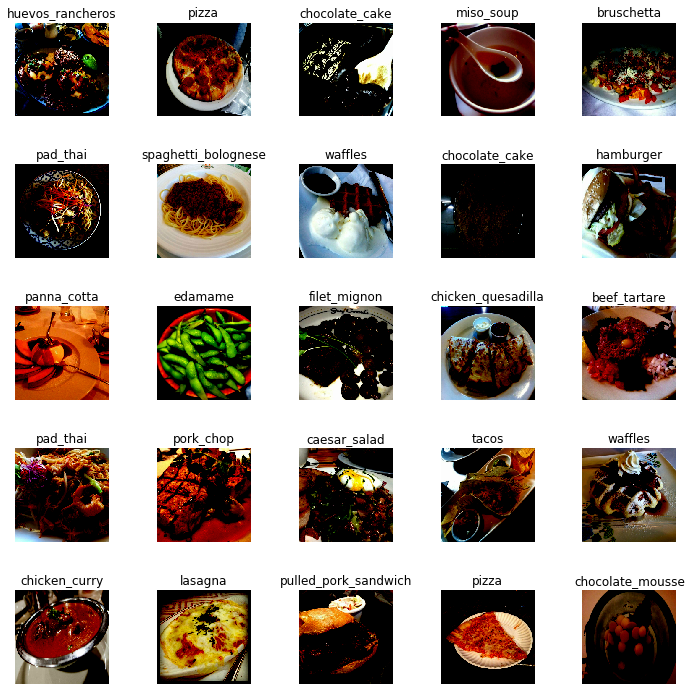

In [0]:
# print out the first 25 images of the Food101 data set
fig, ax = plt.subplots(5,5,figsize=(10,10))
fig.tight_layout()
ax = ax.flatten()

for i in range(25):
    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(food_labels[lbl.numpy()])
    ax[i].axis("off")

In [0]:
# set the architecture fot the fine tuned model
class FineTunedModel(tf.keras.layers.Layer):
    def __init__(self, units, model):
        super(FineTunedModel, self).__init__()
        # take the convolutional part of the pre trained model
        self.base_model = model
        # set the classification part on top of it
        # Two Dense Layers
        self.flatten = Flatten()
        self.connected_layer1 = Dense(units = 512, activation = 'relu')
        self.batch_norm1 = BatchNormalization()
        self.dropout1 = Dropout(0.3)
        self.connected_layer2 = Dense(units = 256, activation = 'relu')
        self.batch_norm2 = BatchNormalization()
        self.dropout2 = Dropout(0.3)
        self.output_layer = Dense(units, activation = 'softmax')
    
    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.connected_layer1(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = self.connected_layer2(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

In [0]:
# create train set and chunk it in batches of size 64
train_set = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_set = train_set.shuffle(buffer_size=10000)
train_set = train_set.batch(64)

# create test set and handle it as one batch
test_set = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(100)

In [0]:
tf.keras.backend.clear_session()

# initialize the model
model = FineTunedModel(n_labels, base_model)
# we take categorical crossentropy as a standard loss
# for multi class classification
cce = tf.keras.losses.CategoricalCrossentropy()
# we take Adam with learning rate 0.0001 as optimizer
optimizer = tf.keras.optimizers.Adam(0.0001)

step = 0

train_accuracies = []
train_losses = []
train_steps = []
test_accuracies = []
test_losses = []
test_steps = []


start = time.process_time()

for epoch in range(5):
    for (x,t) in train_set:
        
        t = tf.reshape(t, shape=[-1])
        
        # turn the labels into one-hot vectors.
        t = tf.one_hot(indices = t, depth = n_labels)
        
        
        # perform a training step.
        with tf.GradientTape() as tape:
            output = model(x)
            loss = cce(t, output)
            gradients = tape.gradient(loss, model.trainable_variables)
            
        # apply gradients.
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
        
        if step % 100 == 0:
            accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
            train_accuracies.append(accuracy)
            train_losses.append(loss)
            train_steps.append(step)
        
            for (x,t) in test_set:
                
                t = tf.reshape(t, shape=[-1])
        
                # turn the labels into one-hot vectors.
                t = tf.one_hot(indices = t, depth = n_labels)
                
                # compute loss and accuracy for the test data.
                output = model(x)
                loss = cce(t, output)
                accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
                
                print("{}. Step:".format(step))
                print("Model loss:", loss.numpy())
                print("Model accuracy:", accuracy)
                
                test_accuracies.append(accuracy)
                test_losses.append(loss)
                test_steps.append(step)

        step += 1
        
end = time.process_time()

0. Step:
Model loss: 4.7432656
Model accuracy: 0.04
100. Step:
Model loss: 2.4175189
Model accuracy: 0.39
200. Step:
Model loss: 2.2744148
Model accuracy: 0.44
300. Step:
Model loss: 2.1409936
Model accuracy: 0.43
400. Step:
Model loss: 2.21095
Model accuracy: 0.54
500. Step:
Model loss: 2.446374
Model accuracy: 0.46
600. Step:
Model loss: 2.484262
Model accuracy: 0.5
700. Step:
Model loss: 2.6105094
Model accuracy: 0.46


In [0]:
print("Time needed for finetuning:", end - start)

Time needed for finetuning: 96765.15152


After over 26 hours of training we have a clearly visible overfitting

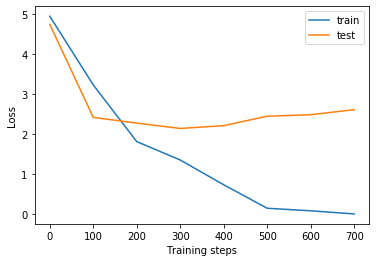

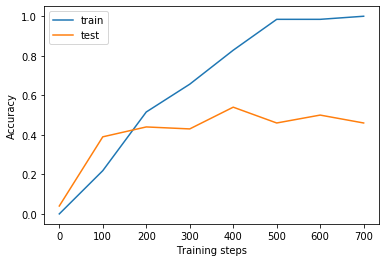

In [0]:
# plot the train and test measures
plt.figure()
line1, = plt.plot(train_steps, train_losses)
line2, = plt.plot(test_steps, test_losses)
plt.legend((line1,line2),("train", "test"))
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

plt.figure()
line1, = plt.plot(train_steps, train_accuracies)
line2, = plt.plot(test_steps, test_accuracies)
plt.legend((line1,line2),("train", "test"))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()